In [1]:
import numpy as np
from scipy import integrate
import torch

import matplotlib
import matplotlib.pyplot as plt

0.36791950647965144


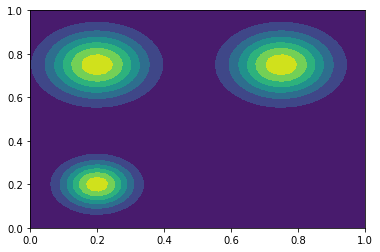

In [2]:
from probability_distribution import mu_gaussians, mu_display2D
U_shape = (1,1)
p1 = mu_gaussians([(0.2, 0.01), (0.75, 0.02), (np.array([0.2, 0.75]), 0.02)], U_shape)
print(p1(np.array([0.2,0.3])))
mu_display2D(p1, U_shape)


In [3]:
from fourier_functions import Fourier_Functions, Fourier_Functions_Visualize2D

mu = p1
K = 3
ff = Fourier_Functions(mu, U_shape, K, printProgress=True)
for k in ff:
    Fourier_Functions_Visualize2D(U_shape, ff[k])


Fourier Functions (mu, U_shape= (1, 1) , K= 3 )...
Computing constants (new_k, h_k, lambda_k)...
Computing torch fourier functions (f_k, df_k)...
Computing mu fourier coefficients (mu_k)... this will take a while because integration...


In [ ]:
from ergodic_agents import Agent, AgentSystem
# can only really test init rn
n = len(U_shape)
all_k = list(np.ndindex(*[K]*n))
agent1 = Agent(0, np.array([0.2, 0.3]), 0.2, all_k, U_shape, ff, eps=1e-5)
for k in agent1.k_bands:
    print("mu"+str(k)+": ", ff[k]["mu_k"])
print("agent1 kbands: ", agent1.k_bands)
print("agent1 ck: ", agent1.get_c_k_log())
print("agent1 ergodicity: ", agent1.get_ergodicity_log())
print("agent1 position: ", agent1.get_position_log())
agent2 = Agent(1, np.array([0.6, 0.5]), 0.2, all_k, U_shape, ff, eps=1e-5)
print(agent2.get_c_k_log())
print(agent2.get_ergodicity_log())
print(agent2.get_position_log())
system1 = AgentSystem([agent1, agent2], mu, U_shape, ff, K)
print(system1.get_c_k_log())
print(system1.get_ergodicity_log())

mu(0, 0):  0.1543442209624029
mu(0, 1):  -0.08192132336295474
mu(0, 2):  0.011260548433379342
mu(1, 0):  0.042007440083285885
mu(1, 1):  0.032151150968839505
mu(1, 2):  0.013669428472842832
mu(2, 0):  0.032267693514379026
mu(2, 1):  -0.00521271716951493
mu(2, 2):  0.004674646978975583
agent1 kbands:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
agent1 ck:  [{(0, 0): array(1.), (0, 1): array(0.83125388), (0, 2): array(-0.43701602), (1, 0): array(1.14412281), (1, 1): array(0.95105652), (1, 2): array(-0.5), (2, 0): array(0.43701602), (2, 1): array(0.36327126), (2, 2): array(-0.19098301)}]
agent1 ergodicity:  [[0.78382698]]
agent1 position:  [[0.2 0.3]]
[{(0, 0): array(1.), (0, 1): array(8.65956056e-17), (0, 2): array(-1.41421356), (1, 0): array(-0.43701602), (1, 1): array(-3.78436673e-17), (1, 2): array(0.61803399), (2, 0): array(-1.14412281), (2, 1): array(-9.90760073e-17), (2, 2): array(1.61803399)}]
[[0.73966193]]
[[0.6 0.5]]
[{(0, 0): 1.0, (0, 1): 0.4156269

In [ ]:
#manually set some stuff


<ipython-input-32-496ac0be7d54>:55: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(0, phi2_max)


AttributeError: 'AgentSystem' object has no attribute 'c_k2distribution'

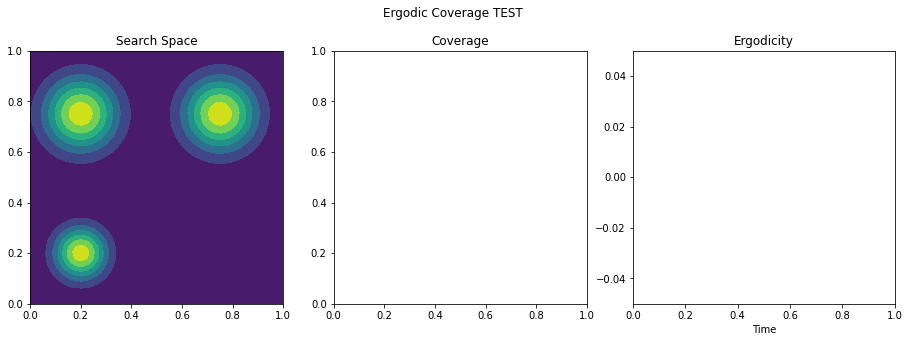

In [ ]:
import matplotlib.animation as animation
import time
""" Animate """ 
filename = "test"
date_and_time = time.strftime("_%Y_%m_%d-%H:%M")
filename = filename + date_and_time
additional_title = "TEST"

# colors = ['r', 'm', 'c', 'y', 'g', 'b', 'k', 'w']
colors = ['maroon', 'cyan', 'red', 'black', 'slateblue', 'orange', 'indigo', 'magenta', 'pink', 'white']
assert system1.num_agents <= len(colors), "does not support this many agents"

fig, ((ax1, ax3, ax2)) = plt.subplots(1, 3, figsize=(6.4*2, 4.8))

fig.suptitle("Ergodic Coverage " + additional_title)

ax1.set_title('Search Space')
ax1.set_aspect('equal')
ax1.set_xlim(0, system1.U_shape[0])
ax1.set_ylim(0, system1.U_shape[1])

X,Y = np.meshgrid(np.linspace(0, system1.U_shape[0]), np.linspace(0, system1.U_shape[1]))
_s = np.stack([X.ravel(), Y.ravel()]).T
ax1.contourf(X, Y, np.array(list(map(system1.mu, _s))).reshape(X.shape))

ax2.set_title('Ergodicity')
ax2.set(xlabel='Time')

ax3.set_title('Coverage')
ax3.set_aspect('equal')
ax3.set_xlim(0, system1.U_shape[0])
ax3.set_xlim(0, system1.U_shape[1])

fig.tight_layout()

pos_data = [([], []) for i in range(system1.num_agents)]
time_data = []
ergodicity_data = []
local_ergodicity_data = [[] for i in range(system1.num_agents)]
pos_lns = []
local_erg_lns = []

for i in range(system1.num_agents):
    pos_ln, = ax1.plot(pos_data[i][0], pos_data[i][1], c=colors[i], label=i)
    pos_lns.append(pos_ln)

    local_erg, = ax2.plot(time_data, local_ergodicity_data[i], c=colors[i], label=i)
    local_erg_lns.append(local_erg)
ergodicity_ln, = ax2.plot(time_data, ergodicity_data, c='b')

def animate2d_init():
    phi2_max = max(system1.e_log)
    time_max = len(system1.e_log)
    ax2.set_xlim(0, time_max)
    ax2.set_ylim(0, phi2_max)
    init_spatial_dist = system1.c_k2distribution(system1.c_k_log[0], system1.all_k_bands)
    cont = ax3.contourf(X, Y, np.array(list(map(init_spatial_dist, _s))).reshape(X.shape))
    return (cont, ergodicity_ln, *local_erg_lns, *pos_lns)


def animate2d_from_logs_update(frame):
    time_data.append(frame)
    for i in range(system1.num_agents):
        pos_data[i][0].append(system1.agents[i].x_log[frame][0])
        pos_data[i][1].append(system1.agents[i].x_log[frame][1])
        pos_lns[i].set_data(pos_data[i][0], pos_data[i][1])

        local_ergodicity_data[i].append(system1.agents[i].e_log[frame])
        local_erg_lns[i].set_data(time_data, local_ergodicity_data[i])
        
    
    ergodicity_data.append(system1.e_log[frame])
    ergodicity_ln.set_data(time_data, ergodicity_data)

    spatial_dist = system1.c_k2distribution(system1.c_k_log[frame], system1.all_k_bands)
    cont = ax3.contourf(X, Y, np.array(list(map(spatial_dist, _s))).reshape(X.shape))
    return (cont, ergodicity_ln, *local_erg_lns, *pos_lns)



update = animate2d_from_logs_update
frames = len(system1.e_log)


FFwriter = animation.writers['ffmpeg']
writer = FFwriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anime = animation.FuncAnimation(fig, animate2d_from_logs_update, init_func=animate2d_init, 
                            frames=frames, interval=20, blit=True)  
plt.show()
if filename is not None:
    anime.save(filename+".mp4", writer=writer) 